# Gestión de carteras

As more realistic constraints are introduced into a mean-variance optimization framework,
we will lose analytical tractability and instead will have to rely on iterative
algorithms. When doing so, it is highly recommended that quants rely on pre-built
optimization procedures instead of trying to create their own. Python, in particular
has a robust set of optimization packages, as we have seen throughout the book. Most
notably, the scipy and cvxpy libraries can be used to solve these types of optimization
problems. Additionally, there are several professional, commercial optimizers that can be leveraged to solve more complex problems. IpOpt, in particular, is an
interior point optimization algorithm that is robust and highly recommended if it is
required to go beyond the scope of Python’s built-in packages. In the next section,
we detail some of the most common constraints that are applied when leveraging
mean-variance techniques in practice.


So far, the only constraints that we have seen utilized in a mean-variance optimization
problem are fully invested constraints. In practice, however, realistic optimization
problems require the inclusion of several additional constraints, some of which may
be equality constraints and others that might be inequality constraints. The following
list details some of the constraints that are most common to embed in a portfolio
optimization problem:
• Long Only Constraint: For many institutions, short positions are either not
allowed or significantly restricted. In these cases, such as mutual funds, they
may only hold long positions resulting in wi > 0 constraints for each asset i.
• Maximum Book Size or Leverage Constraint: When short positions are
allowed, we may want to constrain how much total exposure we have by constraining
the sum of the absolute value of our weights: P
i abs (wi) ≤ B where
B is the maximum allowable book size. Alternatively, we could relax our fully
invested constraint and instead include a leverage constraint that measures the
sum of the weights4, and compares it to a predefined threshold.
• Market Exposure Constraint: We may want to define acceptable ranges
of overall market exposure. In some cases, we may want to have no market
exposure, whereas in other cases we might have a given lower and upper bound.
• Factor Exposure Constraint: Similar to a market exposure constraint, we
may also want to limit the amount of exposure we have to additional risk
factors.
• Tracking Error Constraint: Instead of limiting a portfolio’s overall level of
volatility we may instead want to limit its relative volatility measured against
a benchmark. This is referred to as tracking error and is a common task for
fund managers.
• Max Position Size Constraint: Investors might want to limit how much
weight they put in any individual asset. These limits may be based on the
market capitalization of the underlying assets, and not wanting to own more
than a certain amount of the equity, or may be based on a desire to not have
a portfolio that is too concentrated.
Turnover Constraint: To limit the amount the portfolio changes as we rebalance
over time, and thus minimize transactions costs, we might want to include
a constraint to minimize the deviation of the portfolio from its current weights.
This type of constraint is known as a turnover constraint.
• Daily Volume Constraint: Investors might want to limit their trading in
individual assets based on how much is traded on the asset over the ensuing
period. This would look similar to a turnover constraint, however, would vary
from asset to asset.

# Importamos librerias

In [ ]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Definimos las características de los gráficos

In [ ]:
sns.set_style("whitegrid")

## Recuperamos precios y calculamos rentabilidades

Tienes que autorizar a google colab para tener acceso a tu google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename='tr_eikon_eod_data.csv'
raw = pd.read_csv(filename,index_col=0, parse_dates=True)
print(raw)

                AAPL.O  MSFT.O  INTC.O   AMZN.O    GS.N     SPY     .SPX  \
Date                                                                       
2010-01-01         NaN     NaN     NaN      NaN     NaN     NaN      NaN   
2010-01-04   30.572827  30.950   20.88   133.90  173.08  113.33  1132.99   
2010-01-05   30.625684  30.960   20.87   134.69  176.14  113.63  1136.52   
2010-01-06   30.138541  30.770   20.80   132.25  174.26  113.71  1137.14   
2010-01-07   30.082827  30.452   20.60   130.00  177.67  114.19  1141.69   
...                ...     ...     ...      ...     ...     ...      ...   
2018-06-25  182.170000  98.390   50.71  1663.15  221.54  271.00  2717.07   
2018-06-26  184.430000  99.080   49.67  1691.09  221.58  271.60  2723.06   
2018-06-27  184.160000  97.540   48.76  1660.51  220.18  269.35  2699.63   
2018-06-28  185.500000  98.630   49.25  1701.45  223.42  270.89  2716.31   
2018-06-29  185.110000  98.610   49.71  1699.80  220.57  271.28  2718.37   

           

In [ ]:
symbols = ['SPY', 'GLD', 'AAPL.O', 'MSFT.O']
data = (pd.DataFrame(raw[symbols]).dropna())
print(data)

               SPY     GLD      AAPL.O  MSFT.O
Date                                          
2010-01-04  113.33  109.80   30.572827  30.950
2010-01-05  113.63  109.70   30.625684  30.960
2010-01-06  113.71  111.51   30.138541  30.770
2010-01-07  114.19  110.82   30.082827  30.452
2010-01-08  114.57  111.37   30.282827  30.660
...            ...     ...         ...     ...
2018-06-25  271.00  119.89  182.170000  98.390
2018-06-26  271.60  119.26  184.430000  99.080
2018-06-27  269.35  118.58  184.160000  97.540
2018-06-28  270.89  118.22  185.500000  98.630
2018-06-29  271.28  118.65  185.110000  98.610

[2138 rows x 4 columns]


Voy a crear un índice. Divido los precios actuales con los del momento inicial `data.iloc[0]`

<Axes: xlabel='Date'>

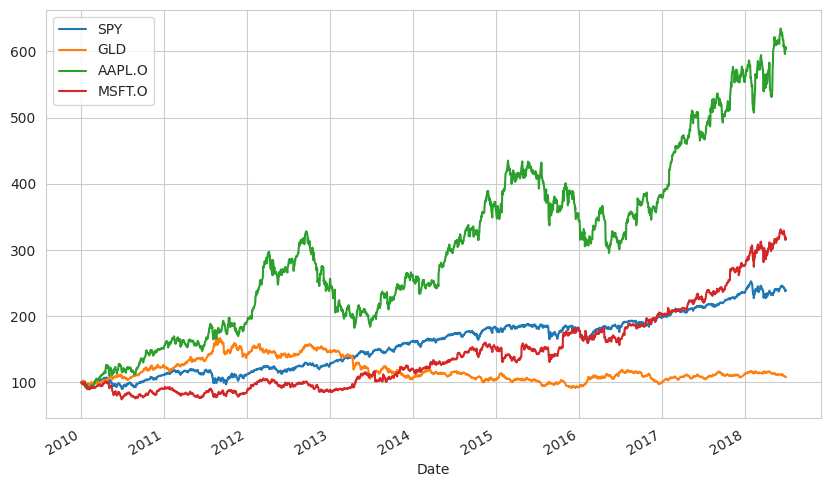

In [ ]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

Vamos a calcular las rentabilidades logarítmicas y posteriormente representar sus histogramas.

bins=50: Este argumento determina la cantidad de "contenedores" o "bins" en los que se agruparán las rentabilidades para crear el histograma. En otras palabras, especifica cuántos intervalos diferentes se utilizarán para dividir el rango de rentabilidades observadas. En tu caso, se han elegido 50 bins, lo que significa que se dividirá el rango total de rentabilidades en 50 intervalos. Un valor más alto de bins proporcionaría un histograma más detallado con más barras, mientras que un valor más bajo de bins daría un histograma más suavizado con menos barras. La elección del número adecuado de bins depende de la distribución de tus datos y de tus preferencias visuales.

figsize=(10, 8): Este argumento controla el tamaño de la figura en la que se muestra el histograma. Es una tupla que especifica el ancho y el alto de la figura en pulgadas. En este caso, la figura tendrá un ancho de 10 pulgadas y una altura de 8 pulgadas. Ajustar el tamaño de la figura puede ser útil para controlar la legibilidad y la presentación del histograma en tu entorno de trabajo. Puedes cambiar estos valores según tus necesidades para obtener una figura que se ajuste mejor a tu diseño.

array([[<Axes: title={'center': 'SPY'}>, <Axes: title={'center': 'GLD'}>],
       [<Axes: title={'center': 'AAPL.O'}>,
        <Axes: title={'center': 'MSFT.O'}>]], dtype=object)

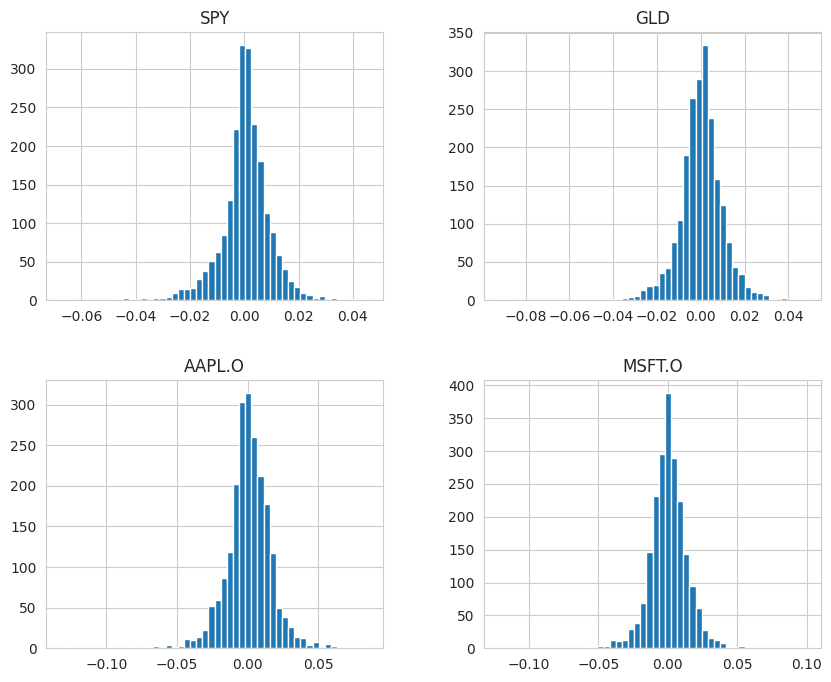

In [ ]:
rets = np.log(data / data.shift(1))
rets.hist(bins=50, figsize=(10, 8))

## Creamos una cartera aleatoria con cuatro títulos

In [ ]:
noa = len(symbols)
print(noa)

4


Los datos están expresados en términos diarios. Consideramos que la

In [ ]:
rets.mean() * 252

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [ ]:
rets.cov() * 252

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


Utilizamos `np.random.random(noa)`para generar 4 números aleatorios que nos ayudarán a generar una cartera aleatoria. Lamentablemente no sumarán uno por lo que los divideremos por la suma de los cuatro dígitos.

In [ ]:
weights = np.random.random(noa)
print(weights)

[0.48612053 0.13339426 0.99749664 0.12473742]


In [ ]:
weights /= np.sum(weights)
print(weights)

[0.2790991  0.07658639 0.57269832 0.07161619]


Calculamos su rentabilidad media

In [ ]:
np.dot(rets.mean().T *252, weights)

0.16083116911920387

Calculamos su varianza y desviación típica

In [ ]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.03270837780744033

In [ ]:
math.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.1808545764072348

Definimos una función que nos permita calcular la rentabilidad esperada de una cartera $(\mu)$.

In [ ]:
def port_ret(weights):
    return np.dot(rets.mean().T *252, weights)

Definimos una función que nos pemita calcular la desviación típica de una cartera $(\sigma)$.

In [ ]:
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Creamos dos listas vacias para guardar las rentabilidades `prets` y las desviaciones típicas `pvols`.

In [ ]:
prets = []
pvols = []

Creamos un bucle donde `p` tomará valores entre 0 y 2499, eso nos permitirá crear 2500 carteras aleatorias.
- Generamos los números aleatorios
- Normalizamos dichos números para convertirlos en ponderaciones.
- Utilizamos las funciones para calcular media y desviación típica de las carteras y las guardamos en las listas vacias vacias `append(port_ret(weights))`

In [ ]:
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))

Convertimos las listas en matrices

In [ ]:
prets = np.array(prets)
pvols = np.array(pvols)

Definimos el gráfico que nos muestre las 2500 carteras generadas de manera aleatoria.
- Definimos el tamaño `plt.figure(figsize=(10, 6))`
- Creamos un gráfico donde cada punto es una cartera que viene definido en el eje de las x por `pvols` y en el eje de las y por `prets`, además le añadimos un mapa de calor `plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')`

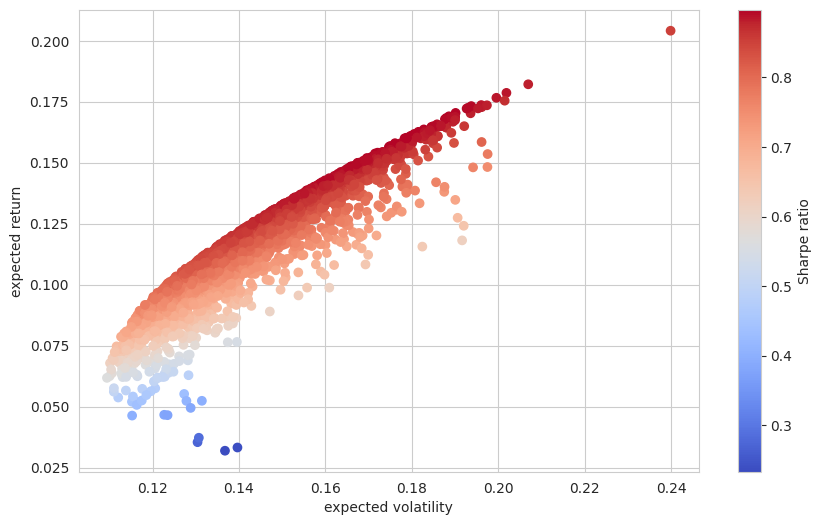

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Cartera eficiente para c=0

In [ ]:
import scipy.optimize as sco

Definimos una función que nos permite estimar al ratio de sharpe a partir de las ponderaciones

In [ ]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

Una tupla en Python es una colección ordenada e inmutable de elementos. Esto significa que:

Ordenada: Los elementos en una tupla tienen un orden definido, lo que significa que puedes acceder a ellos por su posición o índice en la tupla.

Inmutable: Una vez que se crea una tupla, no puedes cambiar sus elementos. Esto significa que no puedes agregar, eliminar o modificar elementos en una tupla después de crearla.

Las tuplas se crean utilizando paréntesis () y pueden contener cualquier tipo de elemento, como números, cadenas de texto, listas u otras tuplas.

Pues vamos a crear un Tupla que vamos a denominar `bnds`.
Vamos a desglosarla paso a paso:

1.  `for x in range(noa)`: Esto es una comprensión de lista. `range(noa)` crea un rango de números que va desde 0 hasta noa - 1.

2. `(0, 1)`: Esto es una tupla que contiene dos elementos: 0 y 1.

3. `tuple(...)`: Esto convierte la tupla (0, 1) en una tupla.



In [ ]:
bnds = tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

Voy a crear un diccionario para incluir las restricciones del proceso de optimización. Un diccionario es una estructura de datos que permite almacenar y organizar información de manera flexible y eficiente. Un diccionario es similar a una lista o una tupla, pero en lugar de utilizar índices numéricos para acceder a sus elementos, utiliza claves (keys) únicas para asociar valores (values). En resumen, un diccionario es una colección de pares clave-valor. Veamos como lo creamos.

1. `{...}`: Esto crea un diccionario en Python. En este caso, el diccionario tiene dos pares clave-valor.

2. `'type': 'eq'`: Este es un par clave-valor en el diccionario. Indica el tipo de restricción. En este caso, `'eq'` significa que es una restricción de igualdad. Esto significa que la función `fun` debe ser igual a cero para que la restricción se cumpla.

3. `'fun': lambda x: np.sum(x) - 1`: Este es otro par clave-valor en el diccionario. Aquí, `'fun'` se refiere a la función que define la restricción. La función está definida como una expresión `lambda` (una función anónima) que toma un argumento `x` y calcula `np.sum(x) - 1`. `np.sum(x)` calcula la suma de los elementos en el vector x, y la restricción establece que esta suma debe ser igual a 1.



In [ ]:
cons = ({'type': 'eq', 'fun': lambda x:np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [ ]:
bnds = tuple((0, 1) for x in range(noa))
cons = ({'type': 'eq', 'fun': lambda x:np.sum(x) - 1})
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

Calculo el ratio de Sharpe de la cartera equiponderada

In [ ]:
min_func_sharpe(eweights)

-0.8436203363155396

Voy a maximizar el ratio de sharpe para ello utilizo la función de optimización.
1. `opts`: creo una variable llamada `opts` que almacenará los resultados de la optimización.

2. `sco.minimize`: Esto es una llamada a la función minimize de la biblioteca SciPy (sco parece ser un alias para scipy.optimize). La función minimize se utiliza para encontrar el mínimo de una función dada.

3. `min_func_sharpe`: Esto parece ser el nombre de la función que se va a minimizar.

4. `eweights`: Este es el punto de partida para la optimización.

5. `method='SLSQP'`: Esto especifica el método de optimización a utilizar. En este caso, se está utilizando el método 'SLSQP', que es una implementación del algoritmo Sequential Least Squares Quadratic Programming (SLSQP) utilizado para resolver problemas de optimización con restricciones.

6. `bounds=bnds`: Esto parece ser un objeto que contiene límites (bounds) para las variables de decisión en la optimización. Todas las ponderaciones deben ser positivas, no estarían permitidas las posiciones cortas.

7. `constraints=cons`: Esto es un objeto que contiene restricciones adicionales para la optimización. La suma de las ponderaciones debe ser igual a 1.


In [ ]:
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8976673894053063
       x: [ 2.545e-01  4.228e-02  5.119e-01  1.913e-01]
     nit: 6
     jac: [-2.460e-04  1.929e-05  8.968e-05  8.304e-05]
    nfev: 30
    njev: 6

In [ ]:
opts['x'].round(3)

array([0.255, 0.042, 0.512, 0.191])

In [ ]:
port_ret(opts['x']).round(3)

0.161

In [ ]:
port_vol(opts['x']).round(3)

0.18

In [ ]:
port_ret(opts['x']) / port_vol(opts['x'])

0.8976673894053063

# Cartera de Mínima Varianza

In [ ]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10942155263468747
       x: [ 5.433e-01  4.557e-01  2.168e-19  1.062e-03]
     nit: 9
     jac: [ 1.094e-01  1.094e-01  1.110e-01  1.095e-01]
    nfev: 45
    njev: 9

In [ ]:
optv['x'].round(3)

array([0.543, 0.456, 0.   , 0.001])

In [ ]:
port_ret(optv['x']).round(3)

0.06

In [ ]:
port_vol(optv['x']).round(3)

0.109

In [ ]:
port_ret(optv['x']) / port_vol(optv['x'])

0.5504173651830081

# Frontera eficiente

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret},
                 {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))

In [ ]:
tuple((0, 1) for x in weights)

Voy a generar los objetivos de rentabilidad `tret`.
1. `np.linspace(0.05, 0.2, 50)`: es una función de NumPy que se utiliza para crear una serie de valores igualmente espaciados. Tiene tres componentes:

  - `0.05`: Este es el primer valor del rango, que especifica el valor inicial de la serie.
  - `0.2`: Este es el segundo valor del rango, que especifica el valor final de la serie.
  - `50`: Este es el número de elementos que tiene la serie.



In [ ]:
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP',bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [ ]:
print(tvols)

[0.11198911 0.11068712 0.10983644 0.10944758 0.10947297 0.10969286
 0.11008001 0.11063305 0.11134938 0.11222585 0.11325876 0.11444387
 0.1157765  0.11725162 0.11886393 0.12060837 0.12247811 0.12446845
 0.12657361 0.12878784 0.13110569 0.13352186 0.13603043 0.13862715
 0.14130693 0.14406512 0.1468973  0.14979927 0.15276706 0.1557969
 0.15888524 0.1620288  0.16522477 0.16846903 0.17175966 0.17509422
 0.17846999 0.18188458 0.18533589 0.18882214 0.19234281 0.19593905
 0.19962547 0.20339717 0.20724919 0.21117744 0.21517764 0.21935776
 0.22394705 0.22892911]


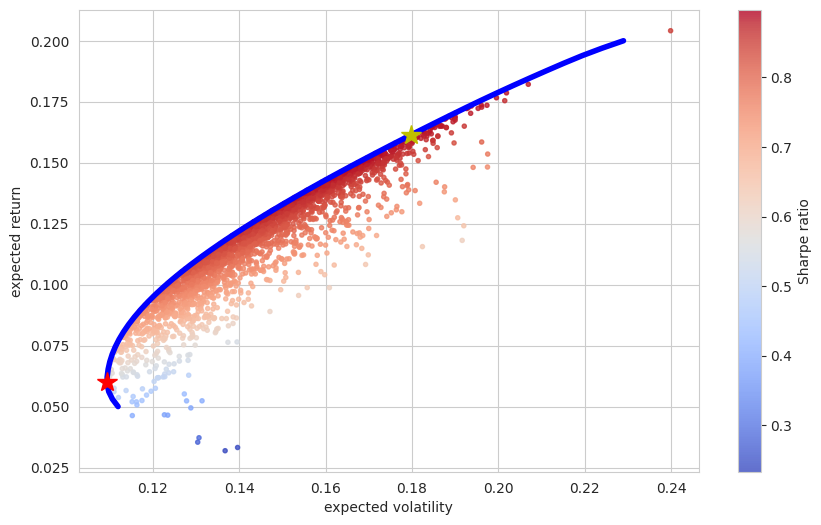

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']),'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']),'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Linea del mercado de capitales

In [ ]:
import scipy.interpolate as sci

'ind = np.argmin(tvols)' identifica dónde esta el valor mínimo de la lista de desviaciones estandars. Es decir, el tercer valor es el mínimo.

In [ ]:
ind = np.argmin(tvols)
print(ind)

3


`evols = tvols[ind:]` selecciono todas las volatilidades a partir de la cartera óptima de mínima varianza.
`erets = trets[ind:]` selecciono todas las rentabilidades a partir de la cartera óptima de mínima varianza.



In [ ]:
evols = tvols[ind:]
erets = trets[ind:]
print()
print(erets evols)

[0.05918367 0.0622449  0.06530612 0.06836735 0.07142857 0.0744898
 0.07755102 0.08061224 0.08367347 0.08673469 0.08979592 0.09285714
 0.09591837 0.09897959 0.10204082 0.10510204 0.10816327 0.11122449
 0.11428571 0.11734694 0.12040816 0.12346939 0.12653061 0.12959184
 0.13265306 0.13571429 0.13877551 0.14183673 0.14489796 0.14795918
 0.15102041 0.15408163 0.15714286 0.16020408 0.16326531 0.16632653
 0.16938776 0.17244898 0.1755102  0.17857143 0.18163265 0.18469388
 0.1877551  0.19081633 0.19387755 0.19693878 0.2       ] [0.10944758 0.10947297 0.10969286 0.11008001 0.11063305 0.11134938
 0.11222585 0.11325876 0.11444387 0.1157765  0.11725162 0.11886393
 0.12060837 0.12247811 0.12446845 0.12657361 0.12878784 0.13110569
 0.13352186 0.13603043 0.13862715 0.14130693 0.14406512 0.1468973
 0.14979927 0.15276706 0.1557969  0.15888524 0.1620288  0.16522477
 0.16846903 0.17175966 0.17509422 0.17846999 0.18188458 0.18533589
 0.18882214 0.19234281 0.19593905 0.19962547 0.20339717 0.20724919
 0.2111

El código `tck = sci.splrep(evols, erets)` se utiliza para realizar una interpolación de splines cúbicos en una serie de datos bidimensionales representados por las listas `evols` y `erets`.

- `sci.splrep`: Esta es una función del módulo scipy.interpolate que se utiliza para calcular los coeficientes de una interpolación de splines cúbicos. Los splines cúbicos son funciones suaves que se utilizan comúnmente para interpolar datos en dos dimensiones.

En resumen, `tck` representa una interpolación de splines cúbicos de los datos contenidos en evols y erets, lo que permite obtener una representación suave de la relación entre las variables x e y en esos datos.

In [ ]:
tck = sci.splrep(evols, erets)
tck

(array([0.10944758, 0.10944758, 0.10944758, 0.10944758, 0.10969286,
        0.11008001, 0.11063305, 0.11134938, 0.11222585, 0.11325876,
        0.11444387, 0.1157765 , 0.11725162, 0.11886393, 0.12060837,
        0.12247811, 0.12446845, 0.12657361, 0.12878784, 0.13110569,
        0.13352186, 0.13603043, 0.13862715, 0.14130693, 0.14406512,
        0.1468973 , 0.14979927, 0.15276706, 0.1557969 , 0.15888524,
        0.1620288 , 0.16522477, 0.16846903, 0.17175966, 0.17509422,
        0.17846999, 0.18188458, 0.18533589, 0.18882214, 0.19234281,
        0.19593905, 0.19962547, 0.20339717, 0.20724919, 0.21117744,
        0.21517764, 0.21935776, 0.22892911, 0.22892911, 0.22892911,
        0.22892911]),
 array([0.05918367, 0.07054273, 0.06082627, 0.07127788, 0.07083661,
        0.07514943, 0.07767382, 0.08086119, 0.08383801, 0.08689314,
        0.08992981, 0.09297762, 0.0960237 , 0.09907511, 0.1021263 ,
        0.10517914, 0.10823306, 0.111288  , 0.11434291, 0.11739981,
        0.12045623, 0.1235

La función `f(x)` que has definido utiliza la interpolación de splines cúbicos que fue calculada previamente en la variable `tck`:
- `def f(x)`: Esto define una función llamada f que toma un argumento x.
- `return sci.splev(x, tck, der=0)`: Dentro de la función, se utiliza `sci.splev` para evaluar la spline cúbica en un valor de `x` dado y devolver el valor interpolado correspondiente en `y`.
-`x`: Es el valor en el eje x en el que deseas evaluar la spline cúbica.
- `tck`: Es la tupla de coeficientes que representa la spline cúbica calculada previamente a partir de tus datos de entrada (evols y erets) utilizando sci.splrep.
- `der=0`: El argumento `der` se utiliza para especificar el orden de la derivada que deseas calcular. En este caso, `der=0` significa que se calcula el valor de la función original (sin derivar).

Entonces, cuando llames a esta función f(x) con un valor de x, obtendrás el valor interpolado correspondiente en y basado en la spline cúbica definida por tck. Esto te permite obtener valores interpolados suaves en función de x a partir de tus datos originales.

Con la función `df(x)` obtendremos los valores de la derivada.

In [ ]:
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

Las condiciones de la línea del mercado de capitales son:

$$\begin{align}
t(x)&=a+bx \\
t(0)&=r_f &\Leftrightarrow a&=r_f \\
t(x)&=f(x) &\Leftrightarrow a+bx&=f(x) \\
t'(x)&=f'(x) &\Leftrightarrow b&=f'(x)
\end{align}$$

$$p=(a,b,x)$$

In [ ]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [ ]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [ ]:
opt

array([0.01      , 0.84470952, 0.19525392])

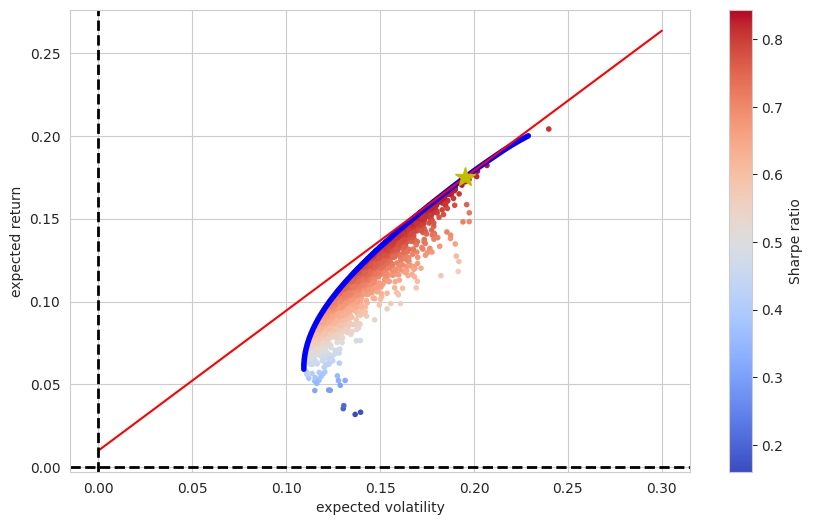

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3) # por defecto genera 50 valores
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')